# Dan & Damion cmpt 370 project

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

load the global and local maps

In [2]:
global_map = cv2.imread('../maps/test_global.png')
global_map = cv2.cvtColor(global_map, cv2.COLOR_RGB2GRAY)
global_map_obstacles = cv2.imread('../maps/test_global_obstacles.png')
global_map_obstacles = cv2.cvtColor(global_map_obstacles, cv2.COLOR_RGB2GRAY)
local_map = cv2.imread('../maps/test_local.png')
local_map = cv2.cvtColor(local_map, cv2.COLOR_RGB2GRAY)

some helper functions for visualization. these functions arent important for the actual localization function but are included to help view whats happening

In [3]:
# pyplot simplification
def imshow(im):
    plt.xticks([]), plt.yticks([])
    plt.imshow(im, cmap="gray")
    plt.show()

In [4]:
# testing function to properly show angles calculated from
# sobel operator. ang should be -pi < ang < pi
def show_ang(ang):
    hue = ang / (2*np.pi)
    hue = hue + 0.5
    hue[hue > 1] = 1.0
    val = np.ones_like(hue)
    sat = np.ones_like(hue)
    val[np.isnan(hue)] = 0
    sat[np.isnan(hue)] = 0
    hue = np.nan_to_num(hue)
    hsv = np.stack((hue, sat, val), axis=-1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(hsv, cmap='hsv')
    plt.show()

In [5]:
# draws an arrow on a point for visualizing poses on maps
def drawArrow(m, px, py, pt):
    line_len = int(min(m.shape)/30)
    line_width = int(min(m.shape)/100)
    circle_width = int(min(m.shape)/75)
    mc = np.copy(m)
    endx = int(px + line_len*np.cos(pt))
    endy = int(py + line_len*np.sin(pt))
    cv2.circle(mc, (px,py), circle_width, 100, thickness=-1)
    return cv2.line(mc, (px,py), (endx, endy), 100, line_width)

helper functions for the main localization algorthm

In [6]:
# generates magnitudes and angles from an image
# mag = (x**2 + y**2)**0.5
# ang = atan(y/x)
# sets pixles where x == 0 to nan
def setup_map(im):
    imx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=5)
    imy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=5)
    mag = np.sqrt(imx**2 + imy**2)
    t = np.ones(im.shape)
    m = (imx == 0) & (imy == 0)
    t[m] = np.nan
    ang = np.where(t == 1, np.arctan2(imy, imx), t)
    return mag, ang

In [7]:
# creates a transformed version of the local map such that
# the local map is padded to the size of the global and
# the poses pg and pl are in the same spot
def transform_local(global_map, local_map, pg, pl):
    # pad local map to be the size of global map
    lh,lw = local_map.shape
    local_pad = np.full(global_map.shape, 0.0, dtype=np.float32)
    local_pad[0:lh,0:lw] = local_map

    # find transform from global to local
    #  create points at the points at next to the points
    pg0 = pg[0], pg[1]
    pg1 = pg[0]+np.cos(pg[2]), pg[1]+np.sin(pg[2])
    pg2 = pg[0]+np.cos(pg[2]+np.pi/2), pg[1]+np.sin(pg[2]+np.pi/2)
    global_points = np.array([pg0,pg1,pg2], dtype=np.float32)

    pl0 = pl[0], pl[1]
    pl1 = pl[0]+np.cos(pl[2]), pl[1]+np.sin(pl[2])
    pl2 = pl[0]+np.cos(pl[2]+np.pi/2), pl[1]+np.sin(pl[2]+np.pi/2)
    local_points = np.array([pl0,pl1,pl2], dtype=np.float32)
    #  get affine transform from points
    tf = cv2.getAffineTransform(local_points, global_points)

    # transform local by found transform
    local_tf = cv2.warpAffine(local_pad, tf, (local_pad.shape[1],local_pad.shape[0]))
    return local_tf

In [8]:
# calculates the weight of a pose.
# requires the maps to be transformed such that the
# poses are overlapping
def calc_weight(global_ang, local_ang, local_mag):
    pixel_weights = 1 - (2 * np.abs(np.arctan(np.sin(local_ang - global_ang) / np.cos(local_ang - global_ang))) / np.pi)
    pixel_weights[pixel_weights<0] = 0
    pixel_weights = pixel_weights * local_mag
    return np.nansum(pixel_weights)

In [9]:
# geneartes n particles normaly distributed around a pose
def generate_particles(pose, point_std, rot_std, n):
    particles = np.random.multivariate_normal((pose[0], pose[1]), [[point_std,0],[0,point_std]], n)
    dirs = np.random.normal(pose[2], rot_std, n)
    particles = np.hstack((particles, dirs[:,np.newaxis]))
    particles = np.vstack((particles, pose))
    return particles

## setup

As this is just a demo notebook some steps have been skipped
 - the local pose we are setting with plx,ply,pla would come from sensor data. As the robot builds the local slam map it keeps track of where the robot is relative to the map so we are just setting this value manualy.
 - the global pose would initially be set by estimating the robots pose in the global map. Here we are setting the pose to a value slightly off of the local pose.
 - as the robot drives around the true pose would drift off of what is calculated through dead reckoning. As new local maps are processed our localization algorithm would need to be re-run with the updated pose estimate. As this is essentially the same problem as localizing from the inital pose estimate we dont show any calculations from after the robot moves.

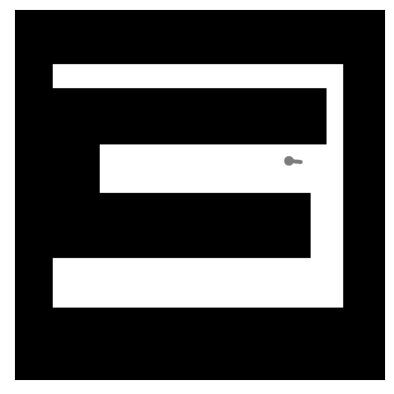

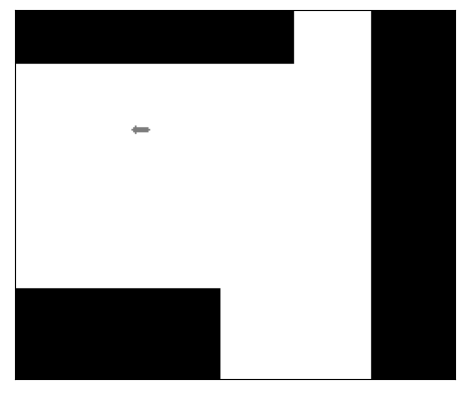

In [10]:
# x,y,rotation coordinates of the estimate for the robots 
# pose in the global map
pgx = 740
pgy = 410
pga = 0.1

# x,y,rotation coordinates of the robots pose in the local map
# this would come from sensor data in the actual robot
plx = 70
ply = 70
pla = 0

global_arrow = drawArrow(global_map, pgx, pgy, pga)
imshow(global_arrow)

local_arrow = drawArrow(local_map, plx, ply, pla)
imshow(local_arrow)

These two maps show the initial pose estimate of the robot in the global map and the true robot 
pose in the local map that would be collected from sensor data. 

Overlaying these two maps show the local pose is in a different spot from the global, open space in the global map is represented by the green channel in the rgb image and open space in the local map is represented by hte red channel. The areas they overlap are shown in yellow.

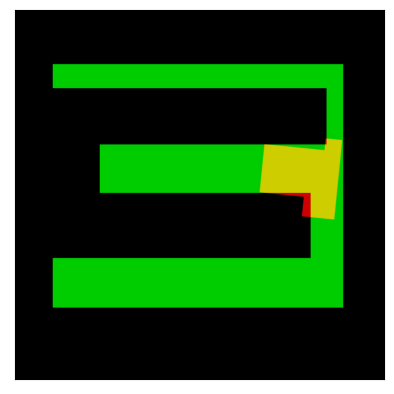

In [11]:
local_transformed = transform_local(global_map, local_map, (pgx,pgy,pga), (plx,ply,pla))
comb = np.stack((local_transformed,global_map,np.zeros_like(global_map)), axis=2)
imshow(comb.astype(np.uint8))

In [12]:
def localize(local_map, global_map, pose_local, pose_global,
             blur_std=30,
             particle_point_std=30,
             particle_rot_std=0.1,
             n_particles=30,
             rounds=3,
             c=0.75,
             it=1,
             verbose=False):
    
    # blur and setup global map
    global_blur = cv2.GaussianBlur(global_map, (51,51), blur_std)
    global_mag, global_ang = setup_map(global_blur.astype(np.float32))

    # generate particles
    particles = generate_particles(pose_global, particle_point_std, particle_rot_std, n_particles)
    
    # find max weight
    best_weight = 0
    best_pose = None
    for particle in particles:
        particle_local_map = transform_local(global_map, local_map, particle, pose_local)
        particle_local_blur = cv2.GaussianBlur(particle_local_map, (51,51), blur_std)
        particle_local_mag, particle_local_ang = setup_map(particle_local_blur)
        weight = calc_weight(global_ang, particle_local_ang, particle_local_mag)
        if weight > best_weight:
            best_weight = weight
            best_pose = particle

    if verbose:
        # show the best map from this recursive round 
        best_local_map = transform_local(global_map, local_map, best_pose, pose_local)
        comb = np.stack((best_local_map,global_map,np.zeros_like(global_map)), axis=2)

        print(f"best pose from round {it}")
        imshow(comb.astype(np.uint8))

    # recursively calling this algorithm with tighter distributions in the particle generation
    # and blur function allows the algorithm to zero in on the highest weight pose with
    # a lower number of particles generated than doing it in one step
    if it < rounds:
        return localize(local_map, global_map, pose_local, best_pose,
                        blur_std=blur_std*c,
                        particle_point_std=particle_point_std*c,
                        particle_rot_std=particle_rot_std*c,
                        n_particles=int(n_particles*c),
                        rounds=rounds,
                        c=c,
                        it=it+1, verbose=verbose)
    else:
        best_local_map = transform_local(global_map, local_map, best_pose, pose_local)
        comb = np.stack((best_local_map,global_map,np.zeros_like(global_map)), axis=2)

        print(f"best pose found")
        imshow(comb.astype(np.uint8))
        return best_pose

    


best pose found


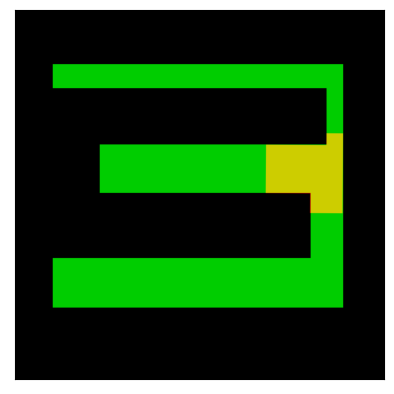

array([7.48226565e+02, 4.05083020e+02, 7.26430734e-03])

In [13]:
localize(local_map, global_map, (plx,ply,pla), (pgx,pgy,pga), n_particles=30, rounds=3)

You may have noticed that this example is pretty much the easisiest possible situation for the algoritm to localize in. As such we should explore some

## strengths and weaknessess of the algorithm

### dealing with imperfect maps

Architectural floor plans of buildings only show solid walls and therefore aren't incredibly accurate to the real world.
For example, object such as tables, chairs, garbage cans etc. are placed throughout the building which show up in local maps and must be accounted for.

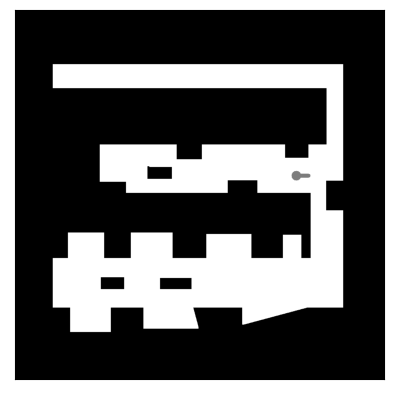

In [14]:
pgx_1 = 760
pgy_1 = 450
pga_1 = 0

obstacles_arrow_1 = drawArrow(global_map_obstacles, pgx_1, pgy_1, pga_1)
imshow(obstacles_arrow_1)

This map is an example of what the map we've been working with may actually look like in real life.
The middle hallway has several objects scattered about which arent shown on the global map.
Even more problematic is the bottom hallway, which could have some glass walls leading to breakoutrooms on either side of it and some tables placed in the middle of the hallway.

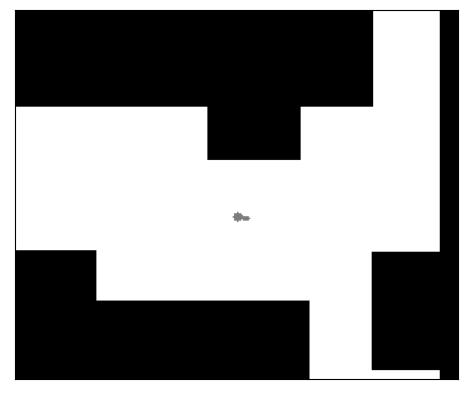

In [15]:
local_map_obstacles_1 = global_map_obstacles[300:550, 600:900]

plx_1 = 150
ply_1 = 140
pla_1 = 0.2

local_obstacles_arrow_1 = drawArrow(local_map_obstacles_1, plx_1, ply_1, pla_1)
imshow(local_obstacles_arrow_1)


In a position like this where there is still a lot of the original detail the algorithm is able to find the correct position with no issues.

best pose found


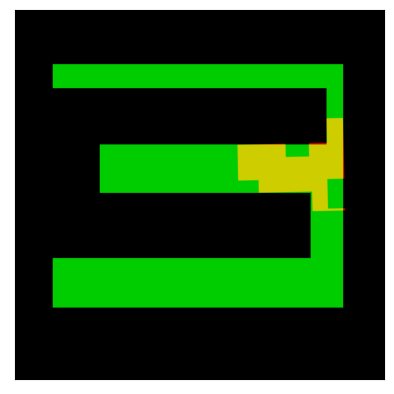

array([7.52738346e+02, 4.37463977e+02, 1.78108839e-01])

In [16]:
localize(local_map_obstacles_1, global_map, (plx_1,ply_1,pla_1), (pgx_1,pgy_1,pga_1))

### dealing with REALY imperfect maps

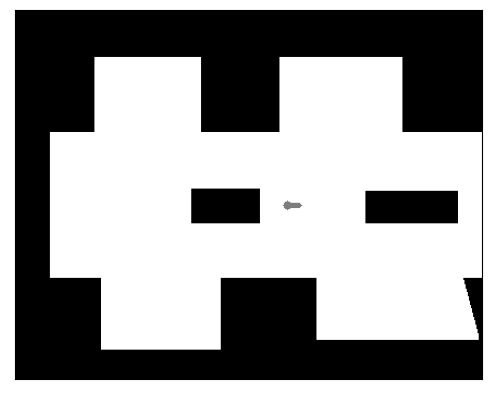

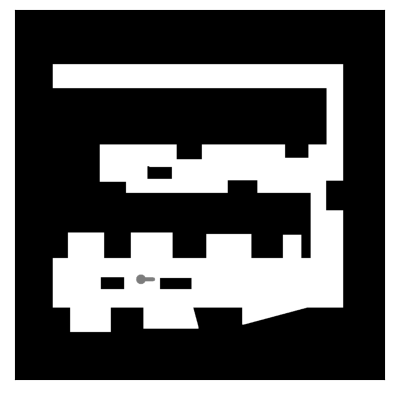

In [17]:
local_map_obstacles_2 = global_map_obstacles[560:900, 70:500]

pgx_2 = 340
pgy_2 = 730
pga_2 = 0 

plx_2 = 250
ply_2 = 180
pla_2 = 0

obstacles_arrow_2 = drawArrow(global_map_obstacles, pgx_2, pgy_2, pga_2)
local_obstacles_arrow_2 = drawArrow(local_map_obstacles_2, plx_2, ply_2, pla_2)

imshow(local_obstacles_arrow_2)
imshow(obstacles_arrow_2)


Localizing in this environment provides a unique challange: there are poses that have a higher weight than the correct one. There are two factors that contribute to this:
 - the width of the cutouts to the north and south of the hallway are wider than the true area of the walls remaining.
 - the objects in the middle of the hallway are spaced far enough from the ends of the cutouts to be dected as the opposite walls when the pose estimate is in a location that the back of the cutouts are detected as the real walls.

feel free to run this cell a few times to see how rarely it find the correct pose

best pose found


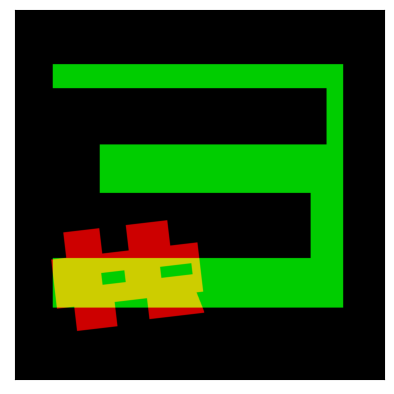

array([ 3.22169875e+02,  7.18152386e+02, -1.16830827e-01])

In [18]:
localize(local_map_obstacles_2, global_map, (plx_2,ply_2,pla_2),(pgx_2,pgy_2,pga_2))

Here the robot consistently fails to localize properly with default parameters in the localization function.

With some tuning however the function starts to be more sucessfull:

feel free to run this cell a few times to see how much more sucessful it is (still not perfect)

best pose found


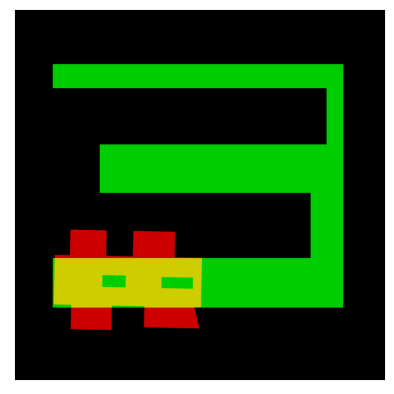

array([3.24046093e+02, 7.35866498e+02, 2.01381719e-02])

In [23]:
localize(local_map_obstacles_2, global_map, (plx_2,ply_2,pla_2), (pgx_2,pgy_2,pga_2), blur_std=7, particle_point_std=15)

The two paramers adjusted were:
 - blur_std: how much the maps were blurred before processing
 - particle_point_std: how far apart the particles are generated

By lowering these values the area the algorithm searches for points is shrunk and the probability of finding incorrect poses that have a higher weight is decreased. It's still not perfect and does find incorrect poses on occasion but is more successful than the base settings.

Lowering these settings does have a downside. If the accuracy of dead reckoning from the rover is low enough it can drift far enough to never find the correct pose again so finding the optimal values of these parameters is a tough balancing act between the accuracy of dead reckoning and how porrly behaved the maps are.

### dealing with low detail 

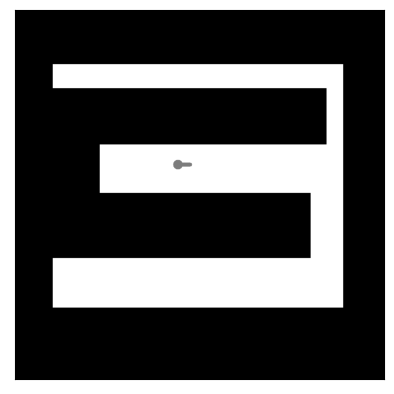

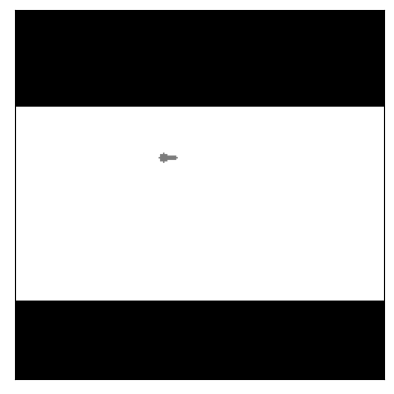

In [24]:
pgx_3 = 440
pgy_3 = 420
pga_3 = 0
global_arrow_3 = drawArrow(global_map, pgx_3, pgy_3, pga_3)

local_map_3 = global_map[300:550,300:550]
plx_3 = 100
ply_3 = 100
pla_3 = 0
local_arrow_3 = drawArrow(local_map_3, plx_3, ply_3, pla_3)

imshow(global_arrow_3)
imshow(local_arrow_3)

In this example, there is no detail constraining where the robot could be along the x direction so the position the algorithm will generate will be somewhere random along the wall.

try running this next cell a few times to see the x value of the best pose change (ive lower the number of particles so it runs faster but the effect is still present with any number)

best pose found


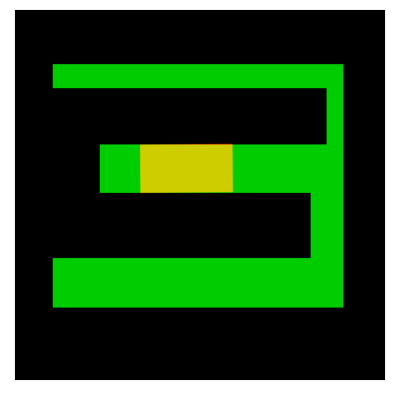

x coord of found best pose 438.1807259477808


In [35]:
print(f"x coord of found best pose {localize(local_map_3, global_map, (plx_3,ply_3,pla_3), (pgx_3,pgy_3,pga_3), n_particles=10)[0]}")